In [ ]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
def extract_zip(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extracted to {extract_to}")

zip_path = "/content/bone_data.zip"
data_dir = "/content/rsna_data"
extract_zip(zip_path, data_dir)

train_dir = os.path.join(data_dir, "boneage-test-dataset")
test_dir = os.path.join(data_dir, "boneage-training-dataset")

Extracted to /content/rsna_data


In [ ]:
def extract_label(filename):
    return int(filename.split('.')[0])

def load_images_labels(image_dir, size=(128, 128)):
    image_paths = []
    labels = []
    for file in os.listdir(image_dir):
        if file.endswith('.png'):
            try:
                label = extract_label(file)
                img_path = os.path.join(image_dir, file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, size)
                img = img / 255.0
                image_paths.append(img)
                labels.append(label)
            except:
                continue
    return np.array(image_paths), np.array(labels, dtype=np.float32)

print("Loading and preprocessing training images...")
X, y = load_images_labels(train_dir)
X = X.reshape(-1, 128, 128, 1)
print(f"Loaded {X.shape[0]} images.")

Loading and preprocessing training images...
Loaded 29 images.


In [ ]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def build_model(input_shape=(128, 128, 1)):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = build_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,391,873 (28.20 MB)

 Trainable params: 7,391,873 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=10
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 20677488.0000 - mae: 4547.2441 - val_loss: 20543998.0000 - val_mae: 4532.5469
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - loss: 20655654.0000 - mae: 4544.8423 - val_loss: 20495172.0000 - val_mae: 4527.1577
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - loss: 20621616.0000 - mae: 4541.0952 - val_loss: 20424886.0000 - val_mae: 4519.3872
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - loss: 20574220.0000 - mae: 4535.8716 - val_loss: 20326408.0000 - val_mae: 4508.4756
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - loss: 20507046.0000 - mae: 4528.4575 - val_loss: 20193122.0000 - val_mae: 4493.6606
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - loss: 20410234.0000 - mae: 4517.7422 - val_loss: 20017290.0000 - val_mae: 4474.0366
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step - loss: 20283418.0000 - mae: 4503.6694 - val_loss: 19790584.0000 - val_mae: 4448.5962
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step - loss: 2011

In [ ]:
y_pred = model.predict(X_val).flatten()

print("MAE:", mean_absolute_error(y_val, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred)))
print("R2 Score:", r2_score(y_val, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
MAE: 4322.81396484375
RMSE: 4323.2094559482075
R2 Score: -1007251.9375


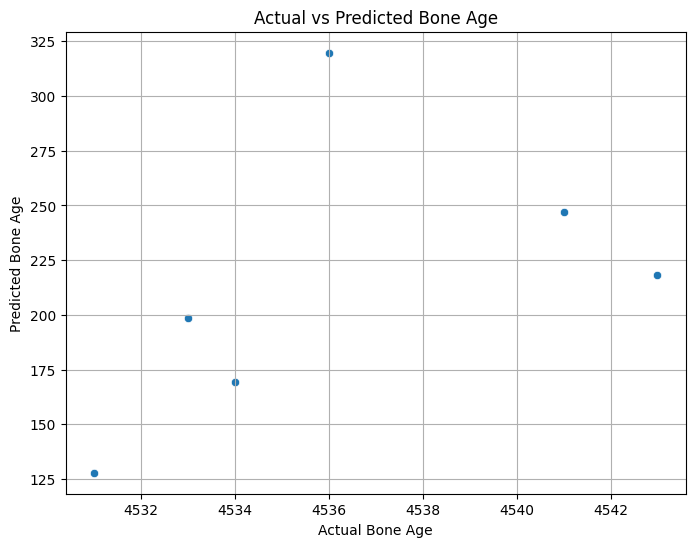

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_val, y=y_pred)
plt.xlabel("Actual Bone Age")
plt.ylabel("Predicted Bone Age")
plt.title("Actual vs Predicted Bone Age")
plt.grid(True)
plt.show()

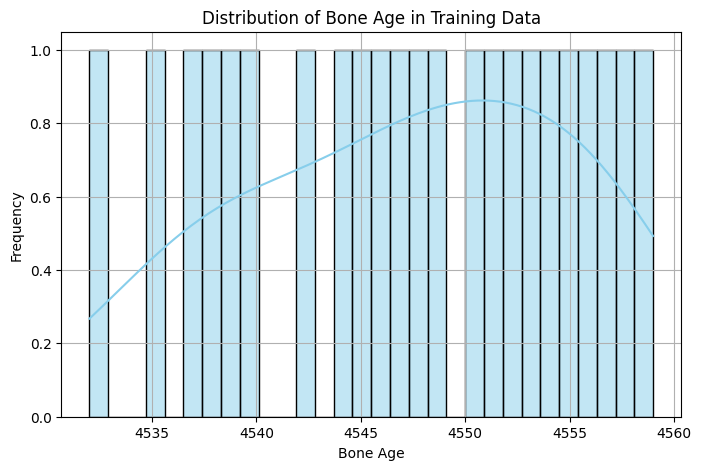

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(y_train, bins=30, kde=True, color='skyblue')
plt.xlabel("Bone Age")
plt.ylabel("Frequency")
plt.title("Distribution of Bone Age in Training Data")
plt.grid(True)
plt.show()

In [ ]:
def prepare_test_images(test_dir, size=(128, 128)):
    paths = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith('.png')]
    images = []
    for p in paths:
        img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, size)
        img = img / 255.0
        images.append(img)
    images = np.array(images).reshape(-1, size[0], size[1], 1)
    return paths, images

test_paths, X_test = prepare_test_images(test_dir)
predictions = model.predict(X_test).flatten()

results = pd.DataFrame({
    'filename': [os.path.basename(p) for p in test_paths],
    'predicted_boneage': predictions
})
results.to_csv("boneage_predictions.csv", index=False)
print("Saved predictions to 'boneage_predictions.csv'")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Saved predictions to 'boneage_predictions.csv'


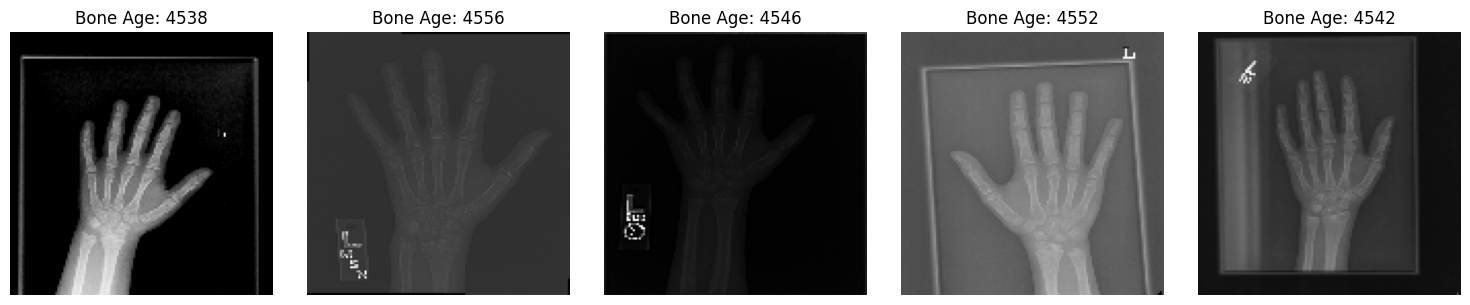

In [ ]:
def show_images(images, labels, n=5):
    plt.figure(figsize=(15, 3))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(images[i].reshape(128, 128), cmap='gray')
        plt.title(f"Bone Age: {int(labels[i])}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_images(X_train, y_train)